# Employee Attrition

The following dataset contains the following fields that describe employee attrition for a company:
    
- satisfaction_level: value between 0 - 1 that describes how satisfied the employee was at their current role
- last_evaluation: value between 0 - 1 that describes how well the employee performed
- number_project: number of projects the employee was on
- average_montly_hours: average number of hours worked monthly time_spend_company: number of years at the company
- work_accident: boolean for if the employee has been in an accident at work
- left: boolean that describes if the employee has left the company
- role: employee's role
- salary: low, medium, high --> indicates how high employee salary was

Can you describe which factors are the strongest indicator if an employee is going to attrit?

## Objective
* To predict whether a liability customer will buy personal loans.
* Which variables are most significant.
* Which segment of customers should be targeted more.

In [1]:
import warnings
warnings.filterwarnings("ignore")

# Libraries to help with reading and manipulating data

import pandas as pd
import numpy as np
from scipy import stats

# Library to split data
from sklearn.model_selection import train_test_split

#libraries to help with model building
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Removes the limit from the number of displayed columns and rows.
# This is so I can see the entire dataframe when I  print it
pd.set_option("display.max_columns", None)
# pd.set_option('display.max_rows', None)
pd.set_option("display.max_rows", 200)

# To build linear model for statistical analysis and prediction
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LogisticRegression

# To get diferent metric scores
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve
from sklearn.model_selection import GridSearchCV

# For pandas profiling
from pandas_profiling import ProfileReport

## Import Dataset

In [2]:
#Loading dataset
dataframe=pd.read_excel("HR_Attrition.xlsx")

In [3]:
dataframe.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [4]:
dataframe.shape

(14999, 10)

In [5]:
dataframe.describe().T

,count,mean,std,min,25%,50%,75%,max
satisfaction_level,14999.0,0.612834,0.248631,0.09,0.44,0.64,0.82,1.0
last_evaluation,14999.0,0.716102,0.171169,0.36,0.56,0.72,0.87,1.0
number_project,14999.0,3.803054,1.232592,2.00,3.00,4.00,5.00,7.0
average_montly_hours,14999.0,201.050337,49.943099,96.00,156.00,200.00,245.00,310.0
time_spend_company,14999.0,3.498233,1.460136,2.00,3.00,3.00,4.00,10.0
Work_accident,14999.0,0.144610,0.351719,0.00,0.00,0.00,0.00,1.0
left,14999.0,0.238083,0.425924,0.00,0.00,0.00,0.00,1.0
promotion_last_5years,14999.0,0.021268,0.144281,0.00,0.00,0.00,0.00,1.0


### Checking for missing values and/or duplicates...

In [6]:
dataframe.isnull().sum() # we saw above that all counts = 10127, so these should all be zero...

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
sales                    0
salary                   0
dtype: int64

In [7]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   sales                  14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [8]:
df = dataframe.copy() # This creates a copy of the dataframe 

## Bivariate Analysis

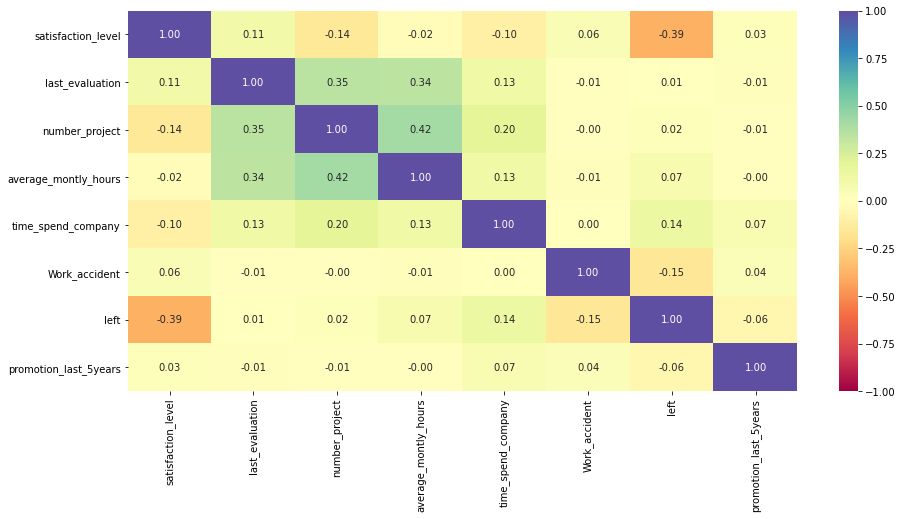

In [9]:
plt.figure(figsize=(15,7))
sns.heatmap(df.corr(),annot=True,vmin=-1,vmax=1,fmt='.2f',cmap='Spectral')
plt.show()

# Methodology

* We want to find Pearson's R values and p-values for each of the independent variables in relation to the dependent Left variable
* First, we need to convert any categorical variables into integers or floats
* We have 2 categorical independent variables: salary and sales
* Salary is a ranked variable.. so we can change this to an integer by mapping numbers corresponding to the ranks of salaries, in this case 0 = low, 1 = medium, 2 = high. This allows us to keep the ranks
* Sales is not ranked so it doesnt make since to map. Instead, we will make dummy variables

In [13]:
df.salary.value_counts()

low       7316
medium    6446
high      1237
Name: salary, dtype: int64

In [14]:
df['salary'] = df['salary'].map({'low': 0, 'medium': 1, 'high': 2
                                        })

In [17]:
df.sales.value_counts()

sales          4140
technical      2720
support        2229
IT             1227
product_mng     902
marketing       858
RandD           787
accounting      767
hr              739
management      630
Name: sales, dtype: int64

In [18]:
df = pd.get_dummies(df, columns=['sales'],drop_first=False)

* The next step is to find the Pearson's R values and the p-values, however, the ultimate goal is to create a single table that is sorted first by p-values (lowest to highest) and then by Pearson's R values (highest to lowest)
* We can do this by creating a series of lists and tables as we proceed 

In [19]:
rows = []
for column_name, column in df.transpose().iterrows():
    rows.append(column_name)

In [20]:
rows2 = []
for column_name, column in df.transpose().iterrows():
     rows2.append(stats.pearsonr(df[column_name],df['left']))

In [21]:
table = pd.DataFrame(rows, columns=["Factor"])

In [22]:
table2 = pd.DataFrame(rows2, columns=["Pearson's R", "p-value"])

In [23]:
table2['p-value'] = table2['p-value'].round(decimals = 4)

In [24]:
table2["Pearson's R"] = table2["Pearson's R"].round(decimals = 4)

In [25]:
table1 = pd.concat([table, table2], axis=1)

In [26]:
table1.sort_values(by = 'p-value', ascending = True)

,Factor,Pearson's R,p-value
0,satisfaction_level,-0.3884,0.0000
13,sales_management,-0.0460,0.0000
3,average_montly_hours,0.0713,0.0000
4,time_spend_company,0.1448,0.0000
5,Work_accident,-0.1546,0.0000
6,left,1.0000,0.0000
7,promotion_last_5years,-0.0618,0.0000
8,salary,-0.1579,0.0000
10,sales_RandD,-0.0466,0.0000
12,sales_hr,0.0282,0.0005


In [30]:
table1.drop([6], axis=0, inplace=True) # this will drop the row Left... since we know it is perfectly correlated with itself

In [31]:
table1.loc[table1['p-value'] == 0].sort_values(by = "Pearson's R", key=abs, ascending = False)

,Factor,Pearson's R,p-value
0,satisfaction_level,-0.3884,0.0
8,salary,-0.1579,0.0
5,Work_accident,-0.1546,0.0
4,time_spend_company,0.1448,0.0
3,average_montly_hours,0.0713,0.0
7,promotion_last_5years,-0.0618,0.0
10,sales_RandD,-0.0466,0.0
13,sales_management,-0.0460,0.0


## Interpretation

- Our goal was to find variables with High R and low p-values because it means that we're able to explain a lot of variation within the data and is significant
- We sorted the Pearson's R value by its absolute value, since whether it is positive or negative simply means that it is positively or negatively correlated with Left, while the aboslute value shows its strength of correlation to Left
- We can ignore Left, since we know that the variable is the dependent variable and is perfectly correlated with itself
- From the above table, we see that satisfaction level is the biggest factor in predicting attrition, it is also negatively correlated to left.  This makes sense, because if someone is unhappy with the company, the score would be lower and he/she would be more likely to leave.  Ie the lower the score, the more likely to leave.
- Salary comes in second, again it is negatively correlated, and this makes sense.  Employees with lower salaries are more likely to leave than employees with higher salaries
- Work place accident is the next most important factor. This is curious because people who have been in an accident (1) are less likely to leave (1).  This could mean their compensation plans are very good, but requires more research to be sure
- The remaining variables can be interpreted the same way... the lower the p-value, the more important the feature is to predicting whether or not the customer will leave, and the higher the absolute value of Pearson's R allows us to explain more of the variation in the data 